In [5]:
import os
import numpy as np
import os
import numpy as np
import tensorflow.compat.v1 as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

tf.disable_v2_behavior()

In [10]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

14.299999999999999
[12.2   12.305 12.41  12.515 12.62  12.725 12.83  12.935 13.04  13.145
 13.25  13.355 13.46  13.565 13.67  13.775 13.88  13.985 14.09  14.195
 14.3  ]


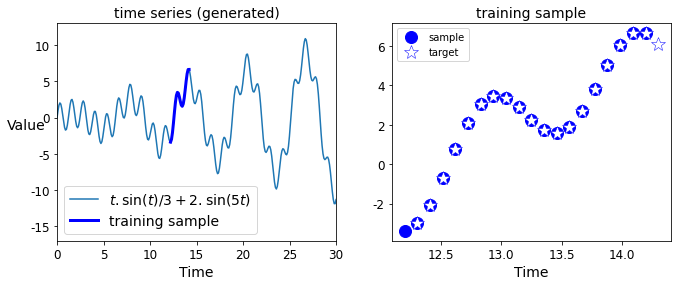

In [19]:
# print(int((t_max - t_min) / resolution))
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))
# print(t)

n_steps = 20

print(12.2 + resolution * (n_steps + 1))
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)
print(t_instance)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="training sample")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value", rotation=0)

plt.subplot(122)
plt.title("training sample", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="sample")
plt.plot(t_instance[1:], time_series(t_instance[1:]), 
         "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [46]:
reset_graph()

################
# Layer Params #
################
n_steps = 20
n_neurons = 100
n_inputs = 1
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [47]:
print(X)
print(y)

Tensor("Placeholder:0", shape=(?, 20, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 20, 1), dtype=float32)


In [48]:
# RNN Model
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:427: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be "
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [49]:
# 하나의 출력을 위한 작업
stacked_rnn_outputs = tf.reshape(tensor=rnn_outputs, shape=[-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
predictions = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [50]:
################
# Train Params #
################
learning_rate = 0.001
n_iterations = 600
batch_size = 50

# loss
mse = tf.losses.mean_squared_error(labels=y, predictions=predictions)
# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

In [51]:
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        batch_x, batch_y = next_batch(batch_size, n_steps)
        sess.run(train_op, feed_dict={X: batch_x, y: batch_y})
        if iteration % 100 == 0:
            loss = mse.eval(feed_dict={X: batch_x, y: batch_y})
            print('step: {:03d}, MSE: {:.4f}'.format(iteration, loss))
            
    # 새로운 데이터 예측하기
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(predictions, feed_dict={X: X_new})
    
print('y_pred:{}\n{}'.format(y_pred.shape, y_pred))

step: 000, MSE: 15.4616
step: 100, MSE: 0.6994
step: 200, MSE: 0.2412
step: 300, MSE: 0.1476
step: 400, MSE: 0.0833
step: 500, MSE: 0.0735
y_pred:(1, 20, 1)
[[[-3.4017992]
  [-2.5594337]
  [-1.3664888]
  [ 0.5682174]
  [ 2.1591384]
  [ 3.1539798]
  [ 3.4332857]
  [ 3.3356404]
  [ 2.8492951]
  [ 2.183525 ]
  [ 1.6153616]
  [ 1.5276922]
  [ 1.8659053]
  [ 2.6722186]
  [ 3.8171256]
  [ 5.1024513]
  [ 6.079029 ]
  [ 6.568311 ]
  [ 6.5740595]
  [ 6.076932 ]]]


<ipython-input-52-a7df40592cb4>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w*" (-> color='w'). The keyword argument will take precedence.
  plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target", color='yellow')


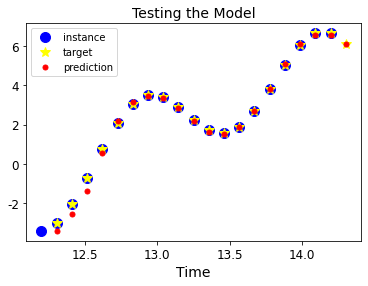

In [52]:
plt.title("Testing the Model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target", color='yellow')
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()